# Example usage of sqrt UKF

This example uses a sqrt UKF to solve a nonlinear observability problem, as described in great detail here: https://iopscience.iop.org/article/10.1088/1748-3182/9/2/025002/meta

The UKF in this package implements the matlab version cited by that paper. The original matlab UKF was written by Nathan Powell, and can be found here: https://github.com/florisvb/dyneye/tree/master/Analysis/Matlab

In [71]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt

In [72]:
import ukf_sqrt.ukf_sqrt as ukf_sqrt

# Load data

In [73]:
mat = scipy.io.loadmat('dyneye_data.mat')

In [74]:
R = mat['R']
Q = mat['Q']
d = mat['position']
v = mat['velocity']
u = mat['control']
t = mat['time']
dt = mat['dt']
flow = mat['optic_flow']
x0 = np.matrix([[10], [-1]])

In [75]:
Q = 1e-6*np.eye(2)
R = 1e-4*np.eye(1)

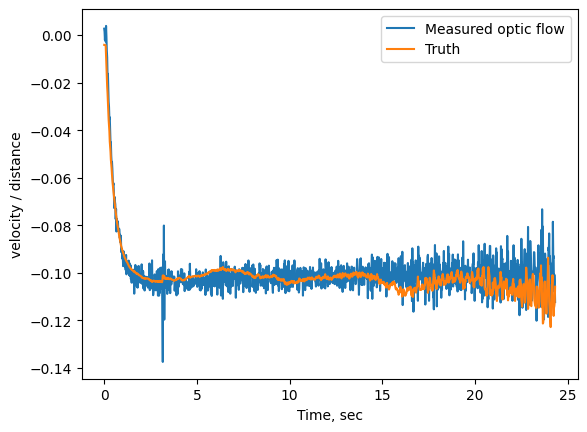

In [76]:
plt.plot(t, flow, label='Measured optic flow')
plt.plot(t, v/d, label='Truth')

plt.xlabel('Time, sec')
plt.ylabel('velocity / distance')

plt.legend()

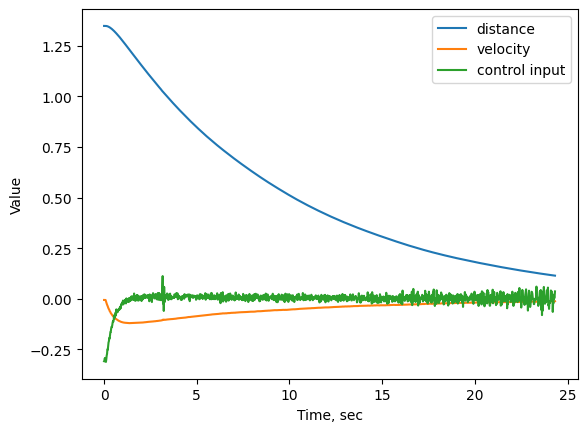

In [77]:
plt.plot(t, d, label='distance')
plt.plot(t, v, label='velocity')
plt.plot(t, u, label='control input')

plt.xlabel('Time, sec')
plt.ylabel('Value')

plt.legend()

# Reformat the measurements and controls

In [78]:
# the measurements
y = np.matrix(flow).T
print(y.shape)

# how many measurements are there?
N = y.shape[1]

(1, 1217)


In [79]:
# the controls (no control)
u = np.matrix(u).T
print(u.shape)

(1, 1217)


# Define measurement and process nonlinear dynamics

In [80]:
# measurement dynamics
def h(x, u, w):
    y = np.vstack((x[1,:]/x[0,:] + w[0, :]))
    return y

In [81]:
# process dynamics
def f(x, u, w):
    d, v = np.ravel(x[:,-1])
    u = np.ravel(u[:,-1])
    xhat = np.vstack((d + v*dt,
                      v + u*dt)) + w
    return xhat

# Make R and Q functions of time

In [82]:
# process covariance
# make it a 3D matrix in time
Qt = np.tile(np.expand_dims(Q, 2), N)

# measurement covariance
# make it a 3D matrix in time
Rt = np.tile(np.expand_dims(R, 2), N)

In [83]:
type(Qt)

numpy.ndarray

# Run the UKF

In [84]:
print(y.shape, x0.shape, Qt.shape, Rt.shape, u.shape)

(1, 1217) (2, 1) (2, 2, 1217) (1, 1, 1217) (1, 1217)


In [85]:
xhat, P, s = ukf_sqrt(y, x0, f, h, Qt, Rt, u, alpha=0.001, beta=2)

# Compare to matlab

In [86]:
matlab_results = scipy.io.loadmat('ukf_matlab_output_with_P_Qe-3.mat')

In [87]:
xf_matlab = matlab_results['xf']

In [88]:
xf_matlab.shape

(2, 1217)

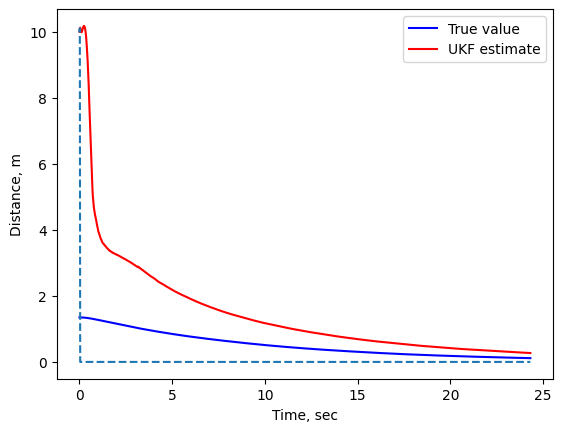

In [89]:
plt.plot(t, d, color='blue', label='True value')
plt.plot(t, xhat[0,:].T, color='red', label='UKF estimate')
plt.plot(t, xf_matlab[0,:].T, '--')

plt.xlabel('Time, sec')
plt.ylabel('Distance, m')

plt.legend()

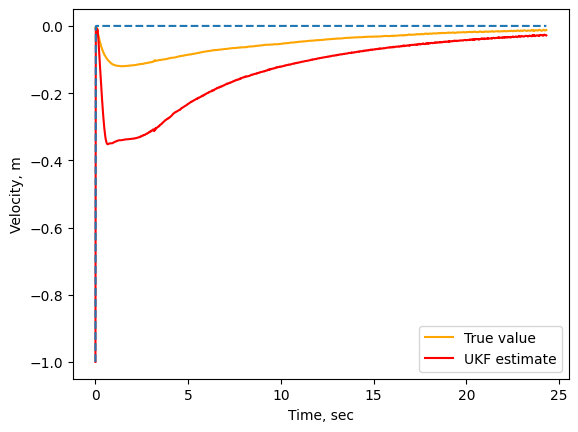

In [90]:
plt.plot(t, v, color='orange', label='True value')
plt.plot(t, xhat[1,:].T, color='red', label='UKF estimate')
plt.plot(t, xf_matlab[1,:].T, '--')

plt.xlabel('Time, sec')
plt.ylabel('Velocity, m')

plt.legend()

# Covariances

In [91]:
Pp_matlab = matlab_results['Pp']
Pv_matlab = matlab_results['Pv']

(0.0, 1.0)

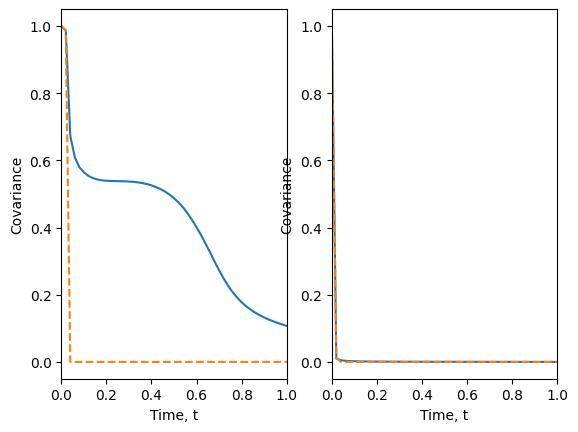

In [92]:
fig = plt.figure()

ax = fig.add_subplot(121)
ax.plot(t, P[0,0,:].T)
ax.plot(t, Pp_matlab, '--')
ax.set_xlabel('Time, t')
ax.set_ylabel('Covariance')
ax.set_xlim(0, 1)

ax = fig.add_subplot(122)
ax.plot(t, P[1,1,:].T)
ax.plot(t, Pv_matlab, '--')
ax.set_xlabel('Time, t')
ax.set_ylabel('Covariance')
ax.set_xlim(0, 1)

